#Proyecto del curso Text Mining and Image Recognition

## Integrantes del grupo
* Otto Rigoberto Ortíz Pérez
* Nery Alejandro Fuentes Torres


## Plano detallado de su jardin


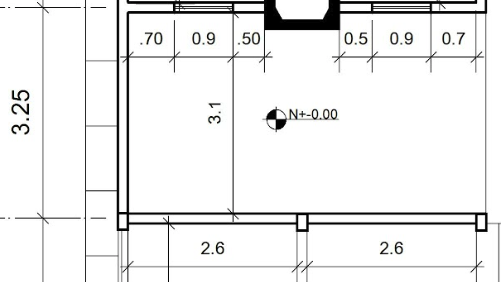


## Foto del jardín completo



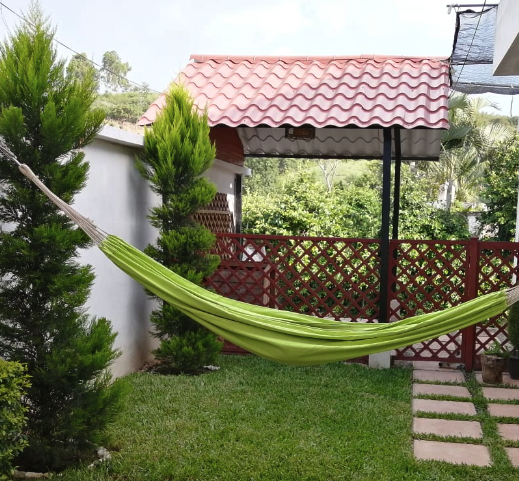

## Metodología a utilizar

### Contando tallos de grama utilizando la Transformada de Hough Generalizada (GHT)

La transformada de Hough permite encontrar formas que pueden ser descritas utilizando ecuaciones, como por ejemplo: líneas y círculos

Para poder encontrar formas que no pueden ser descritas utilizando ecuaciones (como el tallo de la grama) utilizaremos una extensión llamada Transformada de Hough Generalizada.


Para implementar la  Transformada de Hough Generalizada realizaremos los siguientes pasos:
- 1 Cargar una imagen que servirá como plantilla y encontrar los bordes: esta imagen contiene la forma (tallo de grama) que buscaremos en la imagen donde queremos contar la cantidad de tallos
- 2 Listar los puntos del borde de la plantilla.
- 3 Buscar un punto de referencia en el centro de la plantilla a buscar. (Se utilizara la úbicación media en los ejes "y" y "x")
- 4 Calcular un vector $r$ para cada punto del borde (Se debe tomar en cuenta la distancia y el ángulo entre el punto del borde y el centro de la plantilla a buscar) y asignar el mismo a una tabla $ϕ_i$ (tabla R) de acuerdo a su dirección. Esta tabla va a contener todas la posibles direcciones de $r$ en una columna y los vectores $r$ asociados con esa dirección de borde en otra.
- 5 Crear una matriz de acumulación $A(x_c, y_c)$ inicializando cada celda a cero.
  - Para cada punto del borde $(x_i, y_i, ϕ_i)$:
    - Se debe encontrar los vectores asignados a ϕ_i, y realizar lo siguiente para cada entrada: t.
      - Calcular el valor para $A(x_c, y_c) = A(x_c,y_c) + 1$ considerando:
        $x_c =x_i ± r_k^i * cos (α_k^i)$
        $y_c =y_i ± r_k^i * sin (α_k^i)$

- 6 Buscar los máximos locales en la matriz acumulativa usando un umbral que permite detectar varias "instancias" de la plantilla de búsqueda en la imagen.
- 7 Probar la funcionalidad


In [13]:
# Importando paquetes
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [14]:
#Montando carpeta
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1 Cargar una imagen que servirá como plantilla y encontrar los bordes

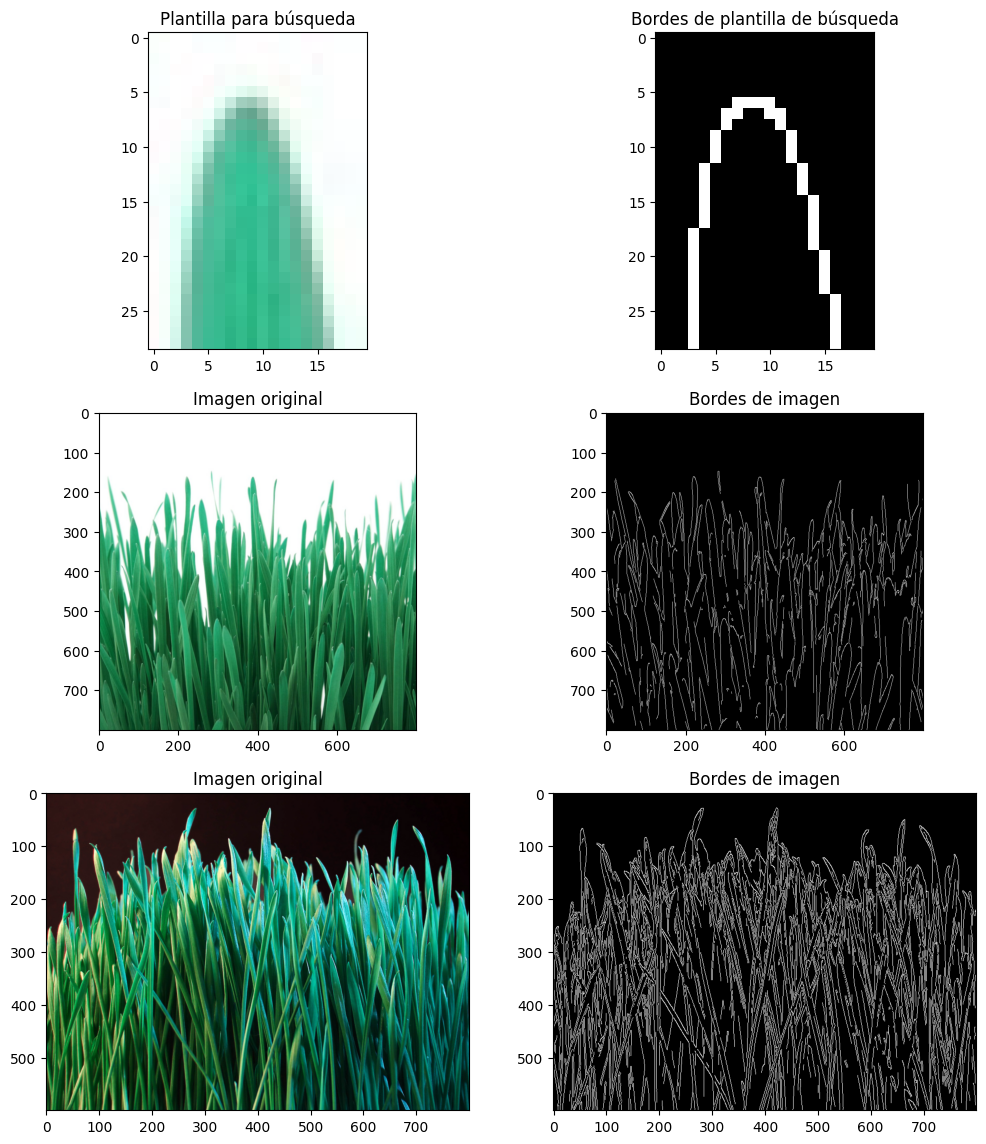

In [15]:
# Cargar plantilla
plantilla = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Text Mining and Image Recognition/Proyecto/plantilla_grama_final.jpeg')
# Convertir a escala de grises
plantilla_escalaGris = cv2.cvtColor(plantilla, cv2.COLOR_BGR2GRAY)
# Encontrar los bordes
plantilla_bordes = cv2.Canny(plantilla_escalaGris, 150, 200)


# Cargar imagen
path = '/content/drive/MyDrive/Colab Notebooks/Text Mining and Image Recognition/Proyecto/images/'
nombreImagenes = ['grama1.jpeg', 'grama5.jpg']



Tot = 2 + len(nombreImagenes)*2
Cols = 2
Rows = Tot // Cols
if Tot % Cols != 0:
    Rows += 1
Position = range(1,Tot + 1)
fig = plt.figure(1,figsize=(12,14))

ax = fig.add_subplot(Rows,Cols,1)
ax.set_title('Plantilla para búsqueda')
ax.imshow(plantilla, cmap='gray')

ax = fig.add_subplot(Rows,Cols,2)
ax.set_title('Bordes de plantilla de búsqueda')
ax.imshow(plantilla_bordes, cmap='gray')

k=2
listaImagenes = []
listaImagenesBordes = []
for i in range(len(nombreImagenes)):
  imagen = cv2.imread(path + nombreImagenes[i])
  # Calcular es ratio del ancho de la imagen para poder redimensionarla
  ancho_final = 800
  r = ancho_final / imagen.shape[1]
  dim = (ancho_final, int(imagen.shape[0] * r))
  # Redimensionar la imagen
  imagen = cv2.resize(imagen, dim, interpolation=cv2.INTER_AREA)
  listaImagenes.append(imagen)
  # Convertir a escala de grises
  imagen_escalaGris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
  # Encontrar los bordes
  imagen_bordes = cv2.Canny(imagen_escalaGris, 100, 200)

  ax = fig.add_subplot(Rows,Cols,Position[k])
  ax.set_title('Imagen original')
  ax.imshow(imagen, cmap='gray')
  k=k+1
  ax = fig.add_subplot(Rows,Cols,Position[k])
  ax.set_title('Bordes de imagen')
  ax.imshow(imagen_bordes, cmap='gray')
  k=k+1
  listaImagenesBordes.append(imagen_bordes)
plt.show()

### 2 Listar los puntos del borde de la plantilla

In [16]:
# Listar los puntos del borde de la plantilla
def listar_coordenadas_borde(image):
  coordenadas = []
  alto, ancho = image.shape
  for i in range(alto):
      for j in range(ancho):
          if (image[i, j]!=0):
              coordenadas.append((i, j))
  return coordenadas

### 3 Buscar un punto de referencia en el centro de la plantilla a buscar

In [17]:
# Buscar un punto de referencia en el centro de la plantilla a buscar
def buscar_punto_referencia(coordenadas):
  x = 0
  y = 0

  for i in range(len(coordenadas)):
      x = x + coordenadas[i][0]
      y = y + coordenadas[i][1]
  x = x/len(coordenadas)
  y = y/len(coordenadas)

  return (int(x), int(y))

### 4 Calcular un vector $r$ para cada punto del borde

In [18]:
# Encontrar direcciones de puntos de borde
def encontrar_orientacion_imagen(image):
  salida = np.zeros(image.shape, image.dtype)
  # Cálculo del gradiente X con el operador Sobel.
  sobel_x = cv2.Sobel(image,cv2.CV_64F,1,0,ksize=5)
  # Cálculo del gradiente Y con el operador Sobel.
  sobel_y = cv2.Sobel(image,cv2.CV_64F,0,1,ksize=5)
  # Calcular la orientación de la imagen (gradiente)
  orientacion = cv2.phase(sobel_x, sobel_y, salida, angleInDegrees=False)
  orientacion = np.absolute(orientacion)
  return orientacion

In [19]:
# Calcular un vector r para cada punto del borde (Se debe tomar en cuenta la distancia y el ángulo entre el
# punto del borde y el centro de la plantilla a buscar) y asignar el mismo a la tabla R de acuerdo a su dirección.
def crear_tabla_R(image, punto_referencia, coordenadas):

  orientacion = encontrar_orientacion_imagen(image) #gradiente
  tabla_R = {}

  for punto in coordenadas:
    rx = punto_referencia[0] - punto[0]
    ry = punto_referencia[1] - punto[1]
    r = (rx, ry)
    phi = orientacion[punto[0], punto[1]]
    if(phi not in list(tabla_R.keys())):
        tabla_R[phi] = [r]
    else:
        tabla_R[phi].append(r)
  return tabla_R


### 5. Crear una matriz de acumulación

In [20]:
# Crear una matriz de acumulación
def buscar_matriz_acumulacion(image_bordes, tabla_R):
  filas = image_bordes.shape[0]
  columnas = image_bordes.shape[1]

  coordenadas_bordes = listar_coordenadas_borde(image_bordes)
  orientacion = encontrar_orientacion_imagen(image_bordes) #gradiente

  acumulador = np.zeros((filas, columnas))

  for i, borde in enumerate(coordenadas_bordes):
    phi = orientacion[borde[0], borde[1]]
    if (phi in list(tabla_R.keys())):
      temp = tabla_R[phi]
      for radius, vector in enumerate(temp):
        x = borde[0] + vector[0]
        y = borde[1] + vector[1]
        if (x>=0 and x<filas) and (y>=0 and y<columnas):
            acumulador[x, y] = acumulador[x, y] + 1
    else:
        continue
  return acumulador


### 6. Buscar los máximos locales en la matriz acumulativa usando un umbral

In [21]:
def buscar_maximos_locales(matriz_acumulacion, umbral):
  max=0
  max_x=0
  max_y = 0
  lista_maximos = []
  x, y = matriz_acumulacion.shape
  for a in range(x):
    for b in range(y):
      #if (matriz_acumulacion[a, b]>max):
      if (matriz_acumulacion[a, b]>umbral):
        lista_maximos.append((a,b))
        #max = matriz_acumulacion[a, b]
        #max_x = a
        #max_y = b
  return lista_maximos

### 7. Probar la funcionalidad

In [22]:
coordenadas_plantilla = listar_coordenadas_borde(plantilla_bordes)
referencia_plantilla = buscar_punto_referencia(coordenadas_plantilla)
tabla_R_plantilla = crear_tabla_R(plantilla_bordes, referencia_plantilla, coordenadas_plantilla)
lista_matriz_acumulacion = []
for imagen_bordes in listaImagenesBordes:
  matriz_acumulacion = buscar_matriz_acumulacion(imagen_bordes, tabla_R_plantilla)
  lista_matriz_acumulacion.append(matriz_acumulacion)

In [23]:
from imutils.object_detection import non_max_suppression

def mostrar_resultados(umbral):
  z=0
  for matriz_acumulacion in lista_matriz_acumulacion:
    lista_maximos_locales = buscar_maximos_locales(matriz_acumulacion, umbral)
    imagen_final = np.copy(listaImagenes[z])
    imagen_final_nms = np.copy(listaImagenes[z])
    z=z+1
    rectangle_size = 8

    rectangulos = []
    for max in lista_maximos_locales:
        max_x = max[0]
        max_y = max[1]
        imagen_final = cv2.rectangle(imagen_final, (max_y+rectangle_size,max_x-rectangle_size),
                                    (max_y-rectangle_size,max_x+rectangle_size)
                                    , (255, 0, 0), 2)
        rectangulos.append((max_y-rectangle_size,max_x-rectangle_size, max_y+rectangle_size,max_x+rectangle_size))

    rectangulosFinales = non_max_suppression(np.array(rectangulos),probs=None, overlapThresh=0.05)
    for (Xi, Yi, Xf, Yf) in rectangulosFinales:
      #imagen_final = cv2.rectangle(imagen_final, (Xi, Yi), (Xf, Yf),(0, 0, 255), 2)
      imagen_final_nms = cv2.rectangle(imagen_final_nms, (Xi, Yi), (Xf, Yf),(0, 0, 255), 2)


    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14,12))
    ax1.set_title('Tallos encontrados sin aplicar non-maxima suppression (NMS): ' + str(len(lista_maximos_locales)))
    ax1.imshow(imagen_final, cmap='gray')
    ax2.set_title('Tallos encontrados después de aplicar non-maxima suppression (NMS): ' + str(len(rectangulosFinales)))
    ax2.imshow(imagen_final_nms, cmap='gray')

    plt.show()

## Output

In [24]:
#pip install ipywidgets
import ipywidgets as widgets
widgets.interact(mostrar_resultados, umbral=widgets.IntSlider(min=10, max=17, step=1, value=15));

interactive(children=(IntSlider(value=15, description='umbral', max=17, min=10), Output()), _dom_classes=('wid…